In [1]:
from flash_diffusion import LDMSevEncoder

/home/zalan/venvs/sevenc/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/zalan/venvs/sevenc/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator12recordStreamERKNS_7DataPtrENS0_10CUDAStreamE
  warn(f"Failed to load image Python extension: {e}")


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/zalan/venvs/sevenc/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/zalan/venvs/sevenc/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/zalan/venvs/sevenc/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


In [2]:
sev_enc = LDMSevEncoder.load_pretrained('checkpoints/sevenc_gblur_celeba256_light.ckpt')

making attention of type 'vanilla' with 512 in_channels


In [3]:
from PIL import Image
from torchvision import transforms
import torch
from data_utils.data_transforms import SevEncInputTransform

# unnormalization transform for plotting
unnormalize = transforms.Compose([
    transforms.Normalize(mean=[-1, -1, -1], std=[1, 1, 1]),
    transforms.Normalize(mean=[0, 0, 0], std=[2.0, 2.0, 2.0]),
])

data_transform = SevEncInputTransform()
sample_img = Image.open('assets/sample.png').convert('RGB')
img_tensor = data_transform(sample_img)

severities = torch.linspace(0, 1, 11)
img_stack = []
pred_severities = []
for sev in severities:
    degraded = sev_enc.fwd_operator(img_tensor, sev) + torch.randn_like(img_tensor) * 0.05
    _, var = sev_enc(degraded)
    img_stack.append(unnormalize(degraded))
    pred_severities.append(var.detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


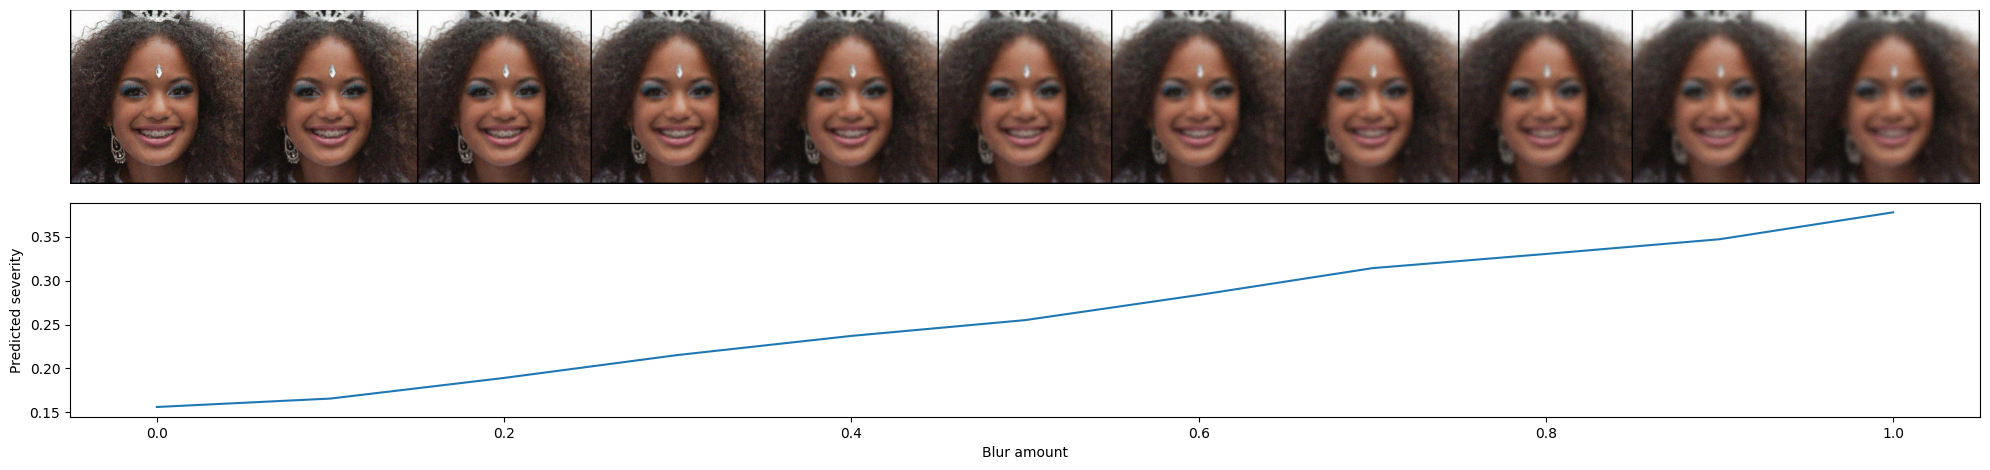

In [4]:
# plot img_stack side-by-side
degr_sequence = torch.cat(img_stack, dim=0)
import matplotlib.pyplot as plt
import torchvision
grid = torchvision.utils.make_grid(degr_sequence, nrow=degr_sequence.shape[0])

# plot degr_sequence and pred_severities under each other
plt.figure(figsize=(20, 5))
plt.subplot(2, 1, 1)
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.subplot(2, 1, 2)
plt.plot(severities, pred_severities)
plt.xlabel('Blur amount')
plt.ylabel('Predicted severity')
plt.tight_layout()
plt.show()


In [5]:
from samplers import LDPS
from flash_diffusion import AdaptiveSampler
from scripts.utils import load_config_from_yaml

In [6]:
# Load config for Gaussian deblurring on FFHQ
experiment_config = load_config_from_yaml('flash_configs/reconstruction_configs/demo.yaml')

In [7]:
# Set up model
baseline_sampler = LDPS(experiment_config['data']['degradation_config'], **experiment_config['baseline'])
flash_sampler = AdaptiveSampler(**experiment_config['adaptation'])
flash_sampler.attach(baseline_sampler)

# # Set up dataset
# sample_img = Image.open('assets/sample.png').convert('RGB')

clean = data_transform(sample_img)

# Degrade image
severity = torch.tensor(0.5)
degraded = flash_sampler.fwd_operator(clean, severity)  + torch.randn_like(img_tensor) * 0.05

# Run reconstruction
recon = flash_sampler.run_single(degraded, severity)['recon']

Loading model from ldm/models/ldm/celeba256/model.ckpt


/home/zalan/venvs/sevenc/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v1.10.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 274.06 M params.
Keeping EMAs of 370.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Training LatentDiffusion as an unconditional model.
making attention of type 'vanilla' with 512 in_channels


Reconstruction: 100%|██████████| 114/114 [00:12<00:00,  9.08it/s]


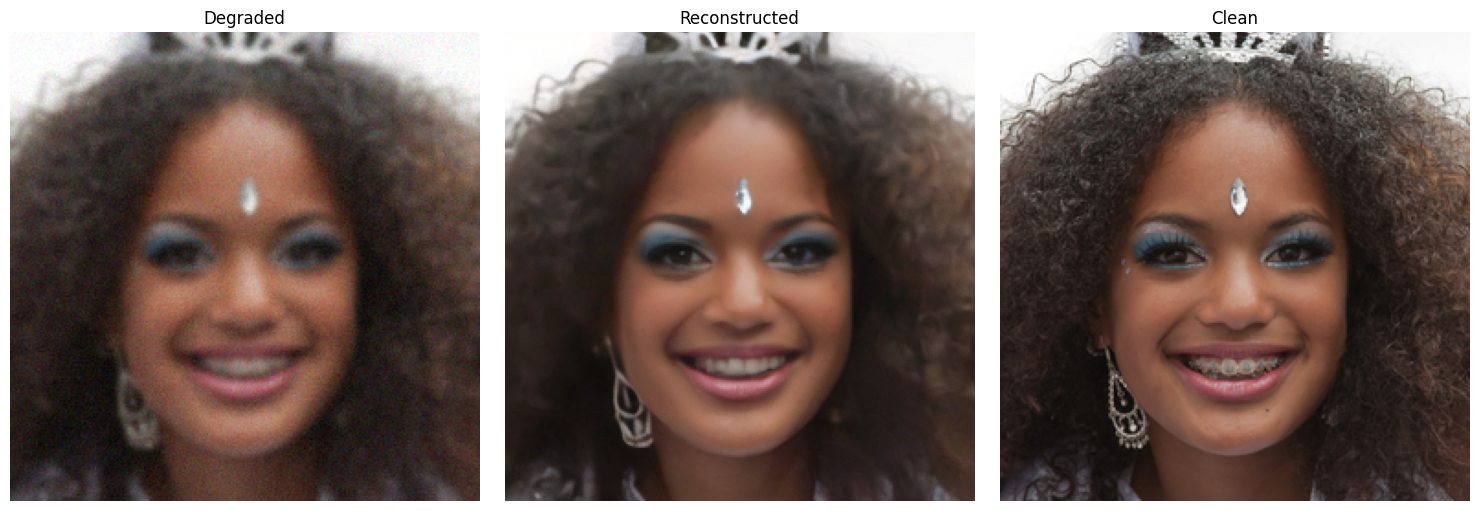

In [8]:
# Visualize reconstruction
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(unnormalize(degraded).squeeze().permute(1, 2, 0).detach().cpu().numpy().clip(0.0, 1.0))
plt.axis('off')
plt.title('Degraded')
plt.subplot(1, 3, 2)
plt.imshow(unnormalize(recon).squeeze().permute(1, 2, 0).detach().cpu().numpy().clip(0.0, 1.0))
plt.axis('off')
plt.title('Reconstructed')
plt.subplot(1, 3, 3)
plt.imshow(unnormalize(clean).squeeze().permute(1, 2, 0).detach().cpu().numpy().clip(0.0, 1.0))
plt.axis('off')
plt.title('Clean')
plt.tight_layout()
plt.show()